<a href="https://colab.research.google.com/github/leonpalafox/LOBMarketMaker/blob/main/MMMarkovTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from abc import ABC
import pkg_resources

# pkg_resources.require("gym==0.22.0")
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
import torch as th
import pickle
import random

import numpy as np

"""
================== CREDITS =======================
The code in this file was written by Hanna Hultin.

"""


class LOB:
    def __init__(self, data, outside_volume=1, include_spread_levels=True):
        self.data = data.reshape((2, -1))
        self.num_levels = self.data.shape[1] - 1
        self.outside_volume = outside_volume
        self.include_spread_levels = include_spread_levels

    @property
    def ask(self):
        return int(self.data[0, 0])

    @property
    def bid(self):
        return int(self.data[0, 0] + self.data[1, 0])

    @property
    def mid(self):
        return (self.bid + self.ask) / 2

    @property
    def vwap_mid(self):
        vwap_a = np.dot(
            self.data[0, 1:], self.bid + 1 + np.arange(self.num_levels)
        ) / np.sum(self.data[0, 1:])
        vwap_b = np.dot(
            -self.data[1, 1:], self.ask - 1 - np.arange(self.num_levels)
        ) / np.sum(-self.data[1, 1:])
        vwap = (vwap_a + vwap_b) / 2
        return vwap

    @property
    def microprice(self):
        bid_volume = self.bid_volume if self.bid_volume != 0 else self.outside_volume
        ask_volume = self.ask_volume if self.ask_volume != 0 else self.outside_volume
        if bid_volume == 0 and ask_volume == 0:
            return self.mid
        else:
            return (self.ask * bid_volume + self.bid * ask_volume) / (
                bid_volume + ask_volume
            )

    @property
    def spread(self):
        return int(-self.data[1, 0])

    @property
    def relative_bid(self):
        return int(self.data[1, 0])

    @property
    def ask_volume(self):
        return (
            0
            if self.spread > self.num_levels
            else (
                self.data[0, self.spread]
                if self.include_spread_levels
                else self.data[0, 1]
            )
        )

    @property
    def bid_volume(self):
        return (
            0
            if self.spread > self.num_levels
            else (
                -self.data[1, self.spread]
                if self.include_spread_levels
                else -self.data[1, 1]
            )
        )

    def buy_n(self, n=1):
        total_price = 0
        level = 0
        while n > 0:
            if level >= self.num_levels:
                available = self.outside_volume
                if self.outside_volume == 0:
                    print("TOO LARGE VOLUME")
                    return total_price
            else:
                available = self.ask_n_volume(level)
            vol = np.min((n, available))
            n -= vol
            total_price += (self.bid + 1 + level) * vol
            level += 1
        return total_price

    def sell_n(self, n=1):
        total_price = 0
        level = 0
        while n > 0:
            if level >= self.num_levels:
                available = self.outside_volume
                if self.outside_volume == 0:
                    print("TOO LARGE VOLUME")
                    return total_price
            else:
                available = self.bid_n_volume(level)
            vol = np.min((n, available))
            n -= vol
            total_price += (self.ask - 1 - level) * vol
            level += 1
        return total_price

    def ask_n(self, n=0, absolute_level=False):
        if n == 0 and not absolute_level:
            return 0
        level = int(self.relative_bid + n + 1) if self.include_spread_levels else n
        if absolute_level:
            level += self.ask
        return level

    def bid_n(self, n=0, absolute_level=False):
        level = -n - 1 if self.include_spread_levels else int(self.relative_bid - n)
        if absolute_level:
            level += self.ask
        return level

    def ask_n_volume(self, n=0):
        return self.data[0, n + 1]

    def bid_n_volume(self, n=0):
        return -self.data[1, n + 1]

    def q_ask(self, num_levels=None):
        if num_levels is None:
            num_levels = self.num_levels
        x = self.data[0, 1 : 1 + num_levels]
        return x

    def q_bid(self, num_levels=None):
        if num_levels is None:
            num_levels = self.num_levels
        x = -self.data[1, 1 : 1 + num_levels]
        return x

    def get_volume(self, level, absolute_level=False):
        if absolute_level:
            level = level - self.ask
        if level == 0:
            return self.ask_volume
        if self.include_spread_levels:
            if (level > 0) and ((self.spread + level - 1) < self.num_levels):
                return self.data[0, self.spread + level]
            elif (level < 0) and ((-level - 1) < self.num_levels):
                return self.data[1, -level]
            else:
                return 0
        else:
            if (level > 0) and (level < self.num_levels):
                return self.data[0, level + 1]
            elif (level < 0) and (-level < self.spread):
                return 0
            elif (level < 0) and (-level - self.spread < self.num_levels):
                return self.data[1, -level - self.spread + 1]
            else:
                return 0

    def order_imbalance(self, depth=None):
        """
        Compute order imbalance for levels up to a specified depth from best bid/ask
        such that high order imbalance means more volume available on bid side (more volume wanting to buy).

        Parameters
        ----------
        depth : int
            specifies how many levels from (and including) best bid and best ask to consider

        Returns
        -------
        float between 0 and 1 of order imbalance

        """
        if depth is None:
            depth = self.num_levels
        vol_sell = np.sum(
            self.data[0, self.spread : self.spread + depth]
            if self.include_spread_levels
            else self.data[0, 1 : 1 + depth]
        )
        vol_buy = np.sum(
            -self.data[1, self.spread : self.spread + depth]
            if self.include_spread_levels
            else -self.data[1, 1 : 1 + depth]
        )
        if vol_buy + vol_sell == 0:
            return 0.5
        else:
            return (vol_buy - vol_sell) / (vol_buy + vol_sell)

    def change_volume(self, level, volume, absolute_level=False, print_info=False):
        if absolute_level:
            level -= self.ask

        offset = self.spread if self.include_spread_levels else 1
        if level == 0:
            if self.ask_volume + volume < -1e-6:
                if print_info:
                    print("LEVEL 0")
                    print(self.data)
                    print("level: ", level)
                    print("volume: ", volume)
                    print(self.ask_volume + volume)
                return False
            self.data[0, np.min([offset, self.num_levels])] = np.round(
                self.data[0, np.min([offset, self.num_levels])] + volume, decimals=6
            )

            # if ask volume 0, move ask
            if self.data[0, offset] == 0:
                old_spread = self.spread
                index = np.argwhere(self.data[0, offset:])
                if index.size == 0:
                    if print_info:
                        print(self.data)
                        print(level)
                        print(volume)
                    move_ask = self.num_levels - offset + 1
                    self.data[0, 0] += move_ask
                    self.data[1, 0] -= move_ask
                    self.data[:, 1:] = 0
                else:
                    move_ask = index.flat[0]
                    self.data[0, 0] += move_ask
                    self.data[1, 0] -= move_ask
                    if self.include_spread_levels:
                        self.data[0, old_spread] = 0
                        self.data[1, 1 + move_ask :] = self.data[1, 1:-move_ask]
                        self.data[1, 1 : 1 + move_ask] = 0
                    else:
                        self.data[0, 1:-move_ask] = self.data[0, 1 + move_ask :]
                        self.data[0, -move_ask:] = self.outside_volume
            return True
        elif level > 0:
            # outside of LOB range
            if level > (self.num_levels - offset):
                return True
            # taking away too much volume not possible
            elif self.data[0, offset + level] + volume < 0:
                return False
            # transition by adding volume on ask side
            else:
                self.data[0, offset + level] = np.round(
                    self.data[0, offset + level] + volume, decimals=6
                )
                return True

        else:
            # outside of LOB range
            if -level > self.num_levels + self.spread - offset:
                return True

            level_index = (
                -level if self.include_spread_levels else -level - self.spread + 1
            )

            # if adding volume inside the spread
            if self.spread + level > 0:
                old_spread = self.spread

                # new bid
                if volume < 0:
                    self.data[1, 0] = level
                    if self.include_spread_levels:
                        self.data[1, -level] = volume
                        self.data[0, 1 : -old_spread - level] = self.data[
                            0, 1 + old_spread + level :
                        ]
                        self.data[0, -old_spread - level :] = self.outside_volume
                    else:
                        self.data[1, 1 + old_spread + level :] = self.data[
                            1, 1 : -(old_spread + level)
                        ]
                        self.data[1, 1 : old_spread + level] = 0
                        self.data[1, old_spread + level] = volume
                    return True

                # new ask
                else:
                    old_ask = self.ask
                    self.data[0, 0] = old_ask + level
                    self.data[1, 0] -= level
                    if self.include_spread_levels:
                        self.data[0, self.spread] = volume
                        self.data[1, 1:level] = self.data[1, 1 - level :]
                        self.data[1, level:] = -self.outside_volume
                    else:
                        self.data[0, 1 + old_spread + level :] = self.data[
                            0, 1 : -(old_spread + level)
                        ]
                        self.data[0, 1 : old_spread + level] = 0
                        self.data[0, old_spread + level] = volume
                    return True

            # taking away too much volume not possible
            elif self.data[1, level_index] + volume > 0:
                return False

            # transition by adding volume on bid side
            else:
                self.data[1, level_index] = np.round(
                    self.data[1, level_index] + volume, decimals=6
                )

                # adjust if best bid changed
                if (self.data[1, level_index] == 0) and (self.relative_bid == level):
                    old_spread = self.spread
                    index = np.argwhere(self.data[1, level_index + 1 :])
                    if index.size == 0:
                        if print_info:
                            print(self.data)
                            print(level)
                            print(volume)
                        move_bid = self.num_levels - offset + 1
                        self.data[1, 0] -= move_bid
                        self.data[:, 1:] = 0
                    else:
                        move_bid = index.flat[0] + 1
                        self.data[1, 0] -= move_bid
                        if self.include_spread_levels:
                            self.data[1, old_spread] = 0
                            self.data[0, 1 + move_bid :] = self.data[0, 1:-move_bid]
                            self.data[0, 1 : 1 + move_bid] = 0
                        else:
                            self.data[1, 1:-move_bid] = self.data[1, 1 + move_bid :]
                            self.data[1, -move_bid] = -self.outside_volume
                return True


def ask(x):
    """
    Compute best ask of limit order book

    Parameters
    ----------
    x : numpy array
        volumes of each level of the order book

    Returns
    -------
    int of ask price

    """
    pa = np.where(x > 0)[0]
    if len(pa) == 0:
        p = len(x)
    else:
        p = pa[0]
    return p


def bid(x):
    """
    Compute best bid of limit order book

    Parameters
    ----------
    x : numpy array
        volumes of each level of the order book

    Returns
    -------
    int of bid price

    """
    pa = np.where(x < 0)[0]
    if len(pa) == 0:
        p = -1
    else:
        p = pa[-1]
    return p


def mid(x):
    """
    Compute mid of limit order book using best bid and best ask

    Parameters
    ----------
    x : numpy array
        volumes of each level of the order book

    Returns
    -------
    int or float of mid price

    """
    return (ask(x) + bid(x)) / 2


def spread(x):
    """
    Compute spread of limit order book

    Parameters
    ----------
    x : numpy array
        volumes of each level of the order book

    Returns
    -------
    int of spread

    """
    return ask(x) - bid(x)


def q_bid(x):
    """
    Computes volumes on bid side by distance from best ask price

    Parameters
    ----------
    x : numpy array
        volumes of each level of the order book

    Returns
    -------
    numpy array with element i containing the volume at distance i from ask

    """
    q = np.zeros(len(x))
    p = ask(x)
    q[:p] = np.flip(x[:p])
    return q


def q_ask(x):
    """
    Computes volumes on ask side by distance from best bid price

    Parameters
    ----------
    x : numpy array
        volumes of each level of the order book

    Returns
    -------
    numpy array with element i containing the volume at distance i from bid

    """
    q = np.zeros(len(x))
    p = bid(x)
    if p >= 0:
        q[: -(p + 1)] = x[p + 1 :]
    else:
        q = x
    return q


def vwap_mid(x):
    """
    Compute volume-weighted average mid of limit order book

    Parameters
    ----------
    x : numpy array
        volumes of each level of the order book

    Returns
    -------
    int or float of vwap mid price

    """
    prices = np.arange(len(x))
    b = bid(x)
    a = ask(x)
    vwap_b = np.dot(x[: b + 1], prices[: b + 1]) / np.sum(x[: b + 1])
    vwap_a = np.dot(x[a:], prices[a:]) / np.sum(x[a:])
    vwap = (vwap_a + vwap_b) / 2
    return vwap


def buy_volume(x, depth):
    """
    Compute volume available on bid size wanting to buy up to specified depth from best bid

    Parameters
    ----------
    x : numpy array
        volumes of each level of the order book
    depth : int
        specifies how many levels from (and including) best bid to consider

    Returns
    -------
    int of volume

    """
    return -np.sum(x[np.maximum(bid(x) - depth, 0) : bid(x) + 1])


def sell_volume(x, depth):
    """
    Compute volume available on ask size wanting to sell up to specified depth from best ask

    Parameters
    ----------
    x : numpy array
        volumes of each level of the order book
    depth : int
        specifies how many levels from (and including) best ask to consider

    Returns
    -------
    int of volume

    """
    return np.sum(x[ask(x) : ask(x) + 1 + depth])


def realized_vol(prices, seq_length=-1):
    """
    Compute realized volatility for each sequence of prices

    Parameters
    ----------
    prices : numpy array
        prices (mid/ask/bid/other) of shape (n,m) with n sequences each of m observations
    seq_length : int
        how long each subsequence should be, if -1 then each sequence considered as one

    Returns
    -------
    numpy array of shape (n,) of realized volatilities for each sequence

    """
    if seq_length != -1:
        num_seq = int(prices.shape[1] / seq_length)
        price_seqs = np.zeros((prices.shape[0], num_seq, seq_length + 1))
        for n in range(num_seq):
            price_seqs[:, n, :] = prices[:, n * seq_length : (n + 1) * seq_length + 1]
        prices = price_seqs.reshape((-1, seq_length + 1))

    return np.std(np.diff(prices, axis=-1), axis=-1)


def order_imbalance(x, depth=None):
    """
    Compute order imbalance for levels up to a specified depth from best bid/ask
    such that high order imbalance means more volume available on bid side (more volume wanting to buy).

    Parameters
    ----------
    x : numpy array
        volumes of each level of the order book
    depth : int
        specifies how many levels from (and including) best bid and best ask to consider

    Returns
    -------
    float between 0 and 1 of order imbalance

    """
    if not depth:
        depth = len(x)
    vol_buy = buy_volume(x, depth)
    vol_sell = sell_volume(x, depth)
    return (vol_buy - vol_sell) / (vol_buy + vol_sell)


def price_signature(p, p0, sizes=None):
    """
    Compute price signature for prices p given reference price p0.

    Parameters
    ----------
    p : numpy array of shape (m,n,d)
        here n is the number of price series for each type of sequence and m is the number of types of such sequences
        d is the number of prices for each price series
    p0 : numpy array of shape (m,n)
        reference price for each price series
    sizes : numpy array of (m,n)
        sizes of the orders to normalize the signature by

    Returns
    -------
    s : numpy array of shape (m, d)

    """
    n = p.shape[1]
    d = p.shape[2]

    p0 = np.tile(p0[:, :, np.newaxis], d)
    if sizes is not None:
        sizes = np.tile(sizes[:, :, np.newaxis], d)
    s = (
        np.sum((p - p0) / sizes, axis=1) / n
        if sizes is not None
        else np.sum(p - p0, axis=1) / n
    )
    return s


def get_volumes(ob, num_levels=10, relative=True, negative_bids=False):
    """
    Compute volume feature vector from ob
    x = (p_ask^1, v_ask^1, p_bid^1, v_bid^1, ...., p_ask^n, v_ask^n, p_bid^n, v_bid^n)
    with p_ask^i being the price level of i:th best ask price (same for bid)
    and v_ask^i the volume of the i:th best ask price (same for bid)

    Parameters
    ----------
    ob : numpy array
        state of the order book
    num_levels : int
        number of levels to consider in feature vector for buy/sell side
    relative : bool
        whether to have all price levels relative to the first ask price or not
    negative_bids : bool
        whether the volumes should be negative on the bid size

    Returns
    -------
    x : numpy array of length 4 * num_levels with extracted features

    """

    x = np.zeros(4 * num_levels)
    x[0] = ask(ob)

    ask_nonzero = ob > 0
    ask_idx = np.argwhere(ask_nonzero)[:num_levels].flatten()
    x[4 : (4 * ask_idx.size) : 4] = ask_idx[1:] - x[0] if relative else ask_idx[1:]
    x[1 : (4 * ask_idx.size + 1) : 4] = ob[ask_idx]

    bid_nonzero = ob < 0
    bid_idx = np.flip(np.argwhere(bid_nonzero).flatten())[:num_levels]
    x[2 : (4 * bid_idx.size + 2) : 4] = bid_idx - x[0] if relative else bid_idx
    x[3 : (4 * bid_idx.size + 3) : 4] = (
        ob[bid_idx] if negative_bids else np.abs(ob[bid_idx])
    )

    return x



"""
================== CREDITS =======================
The code in this file was written by Hanna Hultin.

"""


class MarkovChainLobModel:
    def __init__(
        self, num_levels, rates=None, ob_start=None, include_spread_levels=True
    ):
        """
        Parameters
        ----------
        num_levels : int
            number of levels of the order book
        rates : dict
            rates for different events
        ob_start : numpy array
            starting lob
        include_spread_levels : bool
            whether to include the spread levels in the LOB arrays

        Returns
        -------
        None
        """

        self.num_levels = num_levels
        self.event_types = {
            "lo buy": 0,
            "lo sell": 1,
            "mo bid": 2,
            "mo ask": 3,
            "cancellation buy": 4,
            "cancellation sell": 5,
        }
        self.inverse_event_types = {v: k for k, v in self.event_types.items()}

        self.next_event = None

        self.order_volumes = {"bid": 0, "ask": 0}
        self.order_prices = {"bid": None, "ask": None}

        if rates is None:
            self.rates = self.all_rates()
        else:
            self.rates = rates

        if ob_start is None:
            self.ob = LOB(
                np.zeros((2, self.num_levels + 1), dtype=int),
                include_spread_levels=include_spread_levels,
            )
        else:
            self.ob = LOB(
                ob_start.astype(int), include_spread_levels=include_spread_levels
            )

        self.current_rates = self.update_current_rates()
        return

    @staticmethod
    def geom_dist_probs(alpha, k=10):
        """
        Computes k first probabilities for discrete exponential with parameter alpha

        Parameters
        ----------
        alpha : float
            parameter for the distribution to sample from
        k : int
            number of probabilities

        Returns
        -------
        list of k first probabilities
        """
        return (np.exp(alpha) - 1) * np.exp(-alpha * np.arange(1, k + 1))

    def all_rates(self):
        """
        Compute all rates of the different processes.

        Returns
        -------
        rates : dict
            all rates
        """
        rates = {"mo bid": 0.0467}
        rates["mo ask"] = rates["mo bid"]

        lo_rates = (
            np.array([0.1330, 0.1811, 0.2085, 0.1477, 0.0541])
            + np.array([0.1442, 0.1734, 0.2404, 0.1391, 0.0584])
        ) / 2
        # lo_rates = [.1330, .1811, .2085, .1477, .0541]
        rates["lo buy"] = np.zeros(self.num_levels)
        rates["lo buy"][: min(len(lo_rates), self.num_levels)] = lo_rates[
            : self.num_levels
        ]

        # lo_rates = [.1442, .1734, .2404, .1391, .0584]
        rates["lo sell"] = np.zeros(self.num_levels)
        rates["lo sell"][: min(len(lo_rates), self.num_levels)] = lo_rates[
            : self.num_levels
        ]

        rates["cancellation buy"] = np.zeros(self.num_levels)
        canc_rates = (
            np.array([0.1287, 0.1057, 0.0541, 0.0493, 0.0408])
            + np.array([0.1308, 0.1154, 0.0531, 0.0492, 0.0437])
        ) / 2
        # canc_rates = [.1287, .1057, .0541, .0493, .0408]
        rates["cancellation buy"][: min(len(canc_rates), self.num_levels)] = canc_rates[
            : self.num_levels
        ]
        rates["cancellation sell"] = np.zeros(self.num_levels)
        # canc_rates = [.1308, .1154, .0531, .0492, .0437]
        rates["cancellation sell"][
            : min(len(canc_rates), self.num_levels)
        ] = canc_rates[: self.num_levels]

        rates["lo size"] = 0.5667
        rates["mo size"] = 0.4955

        rates["lo probs"] = self.geom_dist_probs(rates["lo size"], k=self.num_levels)
        rates["mo probs"] = self.geom_dist_probs(rates["mo size"], k=self.num_levels)

        for i in range(self.num_levels):
            for s in ["lo buy", "lo sell", "cancellation buy", "cancellation sell"]:
                rates["{} {}".format(s, i)] = rates[s][i]
        return rates

    def update_current_rates(self):
        """
        Take out the rates for all events that could happen given current state of the order book

        Returns
        -------
            dict of all relevant rates
        """

        self.current_rates = {}
        if self.ob.ask_volume > 0:
            self.current_rates["mo ask"] = self.rates["mo ask"]
        if self.ob.bid_volume > 0:
            self.current_rates["mo bid"] = self.rates["mo bid"]

        for i in range(self.num_levels):
            self.current_rates["lo buy {}".format(i)] = self.rates[
                "lo buy {}".format(i)
            ]
            self.current_rates["lo sell {}".format(i)] = self.rates[
                "lo sell {}".format(i)
            ]

            if self.ob.get_volume(-i - 1) != 0:
                self.current_rates["cancellation buy {}".format(i)] = (
                    np.abs(self.ob.get_volume(-i - 1))
                    * self.rates["cancellation buy {}".format(i)]
                )
            if self.ob.get_volume(self.ob.relative_bid + i + 1) != 0:
                self.current_rates["cancellation sell {}".format(i)] = (
                    np.abs(self.ob.get_volume(self.ob.relative_bid + i + 1))
                    * self.rates["cancellation sell {}".format(i)]
                )
        return self.current_rates

    def update_current_rates_new(self):
        """
        Updates the current rate

        Returns
        -------
        the updated rates
        """

        self.current_rates = {}
        if self.ob.ask_volume > 0:
            self.current_rates["mo ask"] = self.rates["mo ask"]
        if self.ob.bid_volume > 0:
            self.current_rates["mo bid"] = self.rates["mo bid"]

        for i in range(self.num_levels):
            self.current_rates["lo buy {}".format(i)] = self.rates[
                "lo buy {}".format(i)
            ]
            self.current_rates["lo sell {}".format(i)] = self.rates[
                "lo sell {}".format(i)
            ]

            if self.ob.get_volume(-i - 1) != 0:
                if self.ob.bid_n(i, absolute_level=True) == self.order_prices["bid"]:
                    # volume on the mm's level that is not the market maker's
                    other_vol_on_level = (
                        np.abs(self.ob.get_volume(-i - 1)) - self.order_volumes["bid"]
                    )
                    self.current_rates["cancellation buy {}".format(i)] = (
                        other_vol_on_level * self.rates["cancellation buy {}".format(i)]
                    )
                else:
                    self.current_rates["cancellation buy {}".format(i)] = (
                        np.abs(self.ob.get_volume(-i - 1))
                        * self.rates["cancellation buy {}".format(i)]
                    )

            if self.ob.get_volume(self.ob.relative_bid + i + 1) != 0:
                if self.ob.ask_n(i, absolute_level=True) == self.order_prices["ask"]:
                    other_vol_on_level = (
                        np.abs(self.ob.get_volume(self.ob.relative_bid + i + 1))
                        - self.order_volumes["ask"]
                    )
                    self.current_rates["cancellation sell {}".format(i)] = (
                        other_vol_on_level
                        * self.rates["cancellation sell {}".format(i)]
                    )
                else:
                    self.current_rates["cancellation sell {}".format(i)] = (
                        np.abs(self.ob.get_volume(self.ob.relative_bid + i + 1))
                        * self.rates["cancellation sell {}".format(i)]
                    )
        return self.current_rates

    def sample_next_event(self):
        """
        Sample next event given rates, but without performing it and changing the current order book

        Returns
        -------
        the new order book after the transition
        """
        self.next_event = {}
        self.update_current_rates_new()
        with np.errstate(divide="ignore"):
            ts = np.random.exponential(1 / np.array(list(self.current_rates.values())))
        ri = np.argmin(ts)
        self.next_event["time"] = ts[ri]
        k = list(self.current_rates.keys())[ri]
        for (
            ke,
            ve,
        ) in self.event_types.items():
            if k.startswith(ke):
                self.next_event["event"] = ve
        self.next_event["size"] = 1

        if k.startswith("mo"):
            self.next_event["abs_level"] = self.ob.bid if k == "mo bid" else self.ob.ask
            self.next_event["level"] = 0
            ob_volume = self.ob.ask_volume if k == "mo ask" else self.ob.bid_volume
            if ob_volume <= 0:
                print(self.ob.data)
                print(self.next_event)
                print(self.current_rates)
            self.next_event["size"] = self.mo_size(self.rates["mo size"], ob_volume)

            if (
                k == "mo bid"
                and self.next_event["abs_level"] == self.order_prices["bid"]
            ):
                self.order_volumes["bid"] -= np.min(
                    [self.next_event["size"], self.order_volumes["bid"]]
                )
            elif (
                k == "mo ask"
                and self.next_event["abs_level"] == self.order_prices["ask"]
            ):
                self.order_volumes["ask"] -= np.min(
                    [self.next_event["size"], self.order_volumes["ask"]]
                )

        elif k.startswith("lo"):
            i = int(k.rpartition(" ")[-1])
            self.next_event["level"] = i
            self.next_event["size"] = np.random.geometric(
                p=1 - np.exp(-self.rates["lo size"])
            )

            if k.startswith("lo buy"):
                self.next_event["abs_level"] = self.ob.ask - i - 1
            else:
                self.next_event["abs_level"] = self.ob.bid + i + 1
        else:
            i = int(k.rpartition(" ")[-1])
            self.next_event["level"] = i
            self.next_event["abs_level"] = (
                self.ob.ask - i - 1
                if k.startswith("cancellation buy")
                else self.ob.bid + i + 1
            )

        return self.next_event

    def transition(self, event_dict=None):
        """
        Transition the order book according to a given event, if no event is given, samples an event given rates

        Parameters
        ----------
        event_dict : dictionary
            describing next event with
                "event" (int)
                "level" (int)
                "abs_level" (int)
                "size" (int)
                "time" (float)

        Returns
        -------
        the new order book after the transition
        """
        if event_dict is None:
            event_dict = (
                self.sample_next_event()
                if self.next_event is None
                else self.next_event.copy()
            )

        if self.inverse_event_types[event_dict["event"]] in [
            "mo bid",
            "lo sell",
            "cancellation buy",
        ]:
            change_ok = self.ob.change_volume(
                event_dict["abs_level"], event_dict["size"], absolute_level=True
            )
        else:
            change_ok = self.ob.change_volume(
                event_dict["abs_level"], -event_dict["size"], absolute_level=True
            )
        event_dict["ob"] = self.ob.data.copy()
        self.next_event = None
        return event_dict, change_ok

    @staticmethod
    def mo_size(alpha, k):
        """
        Sample the size of a market order

        Parameters
        ----------
        alpha : float
            parameter for the distribution to sample from
        k : int
            current available volume at the touch

        Returns
        -------
        s
            int of size of MO
        """
        p = 1 - np.exp(-alpha)
        s = 0
        while s == 0:
            s = np.random.geometric(p=p)
            if s > k:
                s = 0
        return s

    def simulate(
        self,
        num_events=int(1e3),
        end_time=np.inf,
        num_print=np.inf,
        order_volumes=None,
        order_prices=None,
    ):
        """
        Simulate the order book for a number of events

        Parameters
        ----------
        num_events : int
            number of events
        end_time : float
            max time to simulate
        num_print : int
            how ofter to print current event number

        Returns
        -------
        data_dict
            dictionary containing data about the simulation including
            ob: numpy array of shape (num_events+1, n) containing the LOB in all timesteps
            event: numpy array of event types in all timesteps
            level: numpy array of levels in all timesteps
            abs_level: numpy array of absolute levels in all timesteps
            time: numpy array of time between all events
        """

        data_dict = {
            "ob": np.zeros((num_events + 1, 2, self.num_levels + 1), dtype=int)
        }
        data_dict["ob"][0, ...] = self.ob.data
        data_dict["time"] = np.zeros(num_events)

        if order_volumes is not None and order_prices is not None:
            self.order_volumes = order_volumes.copy()
            self.order_prices = order_prices.copy()
        else:
            self.order_volumes = {"bid": 0, "ask": 0}
            self.order_prices = {"bid": None, "ask": None}

        for k in ["event", "level", "size", "index", "abs_level"]:
            data_dict[k] = np.zeros(num_events, dtype=int)

        data_dict["total_time"] = 0
        for e in range(num_events):
            if (e + 1) % num_print == 0:
                print("event: ", e)

            event_dict = self.sample_next_event()

            if data_dict["total_time"] + event_dict["time"] < end_time:
                data_dict["total_time"] += event_dict["time"]
                self.transition(event_dict)
                for k, v in event_dict.items():
                    if k != "ob":
                        data_dict[k][e] = v
                data_dict["ob"][e + 1, ...] = self.ob.data

            else:
                data_dict["total_time"] = end_time
                data_dict["ob"] = data_dict["ob"][: e + 1, ...]
                for k in ["event", "level", "size", "index", "time", "abs_level"]:
                    data_dict[k] = data_dict[k][:e]
                e -= 1
                break

        data_dict["num_events"] = e + 1
        return data_dict

    def simulate_old(self, num_events=int(1e3), end_time=np.inf, num_print=np.inf):
        """
        Simulate the order book for a number of events

        Parameters
        ----------
        num_events : int
            number of events
        end_time : float
            max time to simulate
        num_print : int
            how ofter to print current event number

        Returns
        -------
        data_dict
            dictionary containing data about the simulation including
            ob: numpy array of shape (num_events+1, n) containing the LOB in all timesteps
            event: numpy array of event types in all timesteps
            level: numpy array of levels in all timesteps
            abs_level: numpy array of absolute levels in all timesteps
            time: numpy array of time between all events
        """

        data_dict = {
            "ob": np.zeros((num_events + 1, 2, self.num_levels + 1), dtype=int)
        }
        data_dict["ob"][0, ...] = self.ob.data
        data_dict["time"] = np.zeros(num_events)

        for k in ["event", "level", "size", "index", "abs_level"]:
            data_dict[k] = np.zeros(num_events, dtype=int)

        data_dict["total_time"] = 0
        for e in range(num_events):
            if (e + 1) % num_print == 0:
                print("event: ", e)

            event_dict = self.sample_next_event()

            if data_dict["total_time"] + event_dict["time"] < end_time:
                data_dict["total_time"] += event_dict["time"]
                self.transition(event_dict)
                for k, v in event_dict.items():
                    if k != "ob":
                        data_dict[k][e] = v
                data_dict["ob"][e + 1, ...] = self.ob.data

            else:
                data_dict["total_time"] = end_time
                data_dict["ob"] = data_dict["ob"][: e + 1, ...]
                for k in ["event", "level", "size", "index", "time", "abs_level"]:
                    data_dict[k] = data_dict[k][:e]
                e -= 1
                break

        data_dict["num_events"] = e + 1
        return data_dict

    def run_twap(
        self, volume, end_time, timefactor=100, initial_ob=None, padding=(0, 0)
    ):
        """
        Runs a TWAP buying the volume with timedelta between each buy.

        Parameters
        ----------
        volume : int
            total volume to buy
        end_time : float
            total time to simulate
        timefactor : float
            how often to save mid/ask/bid of order book
        initial_ob : numpy array
            starting point of the LOB
        padding : tuple of two floats
            how much time to add before the first trade/after the last

        Returns
        -------
        twap_dict
            dictionary containing information about the twap
        """
        if type(initial_ob) is dict:
            initial_ob = initial_ob["ob"]
        if initial_ob is not None:
            self.ob = LOB(initial_ob.copy(), self.ob.include_spread_levels)

        total_time = 0
        twap_dict = {}

        if volume > 1:
            timedelta = (end_time - padding[0] - padding[1]) / (volume - 1)
        else:
            timedelta = 1

        num_times = int(end_time * timefactor) + 2
        for s in ["mid_vals", "ask_vals", "bid_vals"]:
            twap_dict[s] = np.zeros(num_times)
        twap_dict["mid_vals"][0] = self.ob.mid
        twap_dict["ask_vals"][0] = self.ob.ask
        twap_dict["bid_vals"][0] = self.ob.bid
        twap_dict["time_vals"] = np.zeros(num_times + 1)
        twap_dict["time_vals"][:-1] = np.linspace(
            -(1 / timefactor), end_time, num_times
        )
        twap_dict["time_vals"][-1] = np.inf
        time_index = 1

        twap_dict["num_events"] = 0
        twap_dict["num_mo"] = 0

        mid_current = self.ob.mid
        ask_current = self.ob.ask
        bid_current = self.ob.bid

        while total_time < padding[0]:
            twap_dict["num_events"] += 1
            event_dict = self.sample_next_event()
            total_time += event_dict["time"]
            if total_time < padding[0]:
                self.transition()
                if self.inverse_event_types[event_dict["event"]] in [
                    "mo bid",
                    "mo ask",
                ]:
                    twap_dict["num_mo"] += 1
            else:
                total_time = padding[0]

            while total_time > twap_dict["time_vals"][time_index]:
                twap_dict["mid_vals"][time_index] = mid_current
                twap_dict["ask_vals"][time_index] = ask_current
                twap_dict["bid_vals"][time_index] = bid_current
                time_index += 1

            mid_current = self.ob.mid
            ask_current = self.ob.ask
            bid_current = self.ob.bid

        volume_left = volume - 1
        event_dict = {
            "event": self.event_types["mo ask"],
            "abs_level": self.ob.ask,
            "size": 1,
            "index": 1,
            "level": 0,
        }
        twap_dict["price"] = self.ob.ask
        self.transition(event_dict)

        mid_current = self.ob.mid
        ask_current = self.ob.ask
        bid_current = self.ob.bid

        if total_time == twap_dict["time_vals"][time_index]:
            twap_dict["mid_vals"][time_index] = mid_current
            twap_dict["ask_vals"][time_index] = ask_current
            twap_dict["bid_vals"][time_index] = bid_current
            time_index += 1

        for v in range(volume_left):
            while total_time < (padding[0] + timedelta * (v + 1)):
                twap_dict["num_events"] += 1
                event_dict = self.sample_next_event()
                total_time += event_dict["time"]
                if total_time < (padding[0] + timedelta * (v + 1)):
                    self.transition()
                    if self.inverse_event_types[event_dict["event"]] in [
                        "mo bid",
                        "mo ask",
                    ]:
                        twap_dict["num_mo"] += 1

                else:
                    total_time = padding[0] + timedelta * (v + 1)
                    twap_dict["price"] += self.ob.ask
                    event_dict = {
                        "event": self.event_types["mo ask"],
                        "abs_level": self.ob.ask,
                        "size": 1,
                        "level": 0,
                    }
                    self.transition(event_dict)

                while total_time > twap_dict["time_vals"][time_index]:
                    twap_dict["mid_vals"][time_index] = mid_current
                    twap_dict["ask_vals"][time_index] = ask_current
                    twap_dict["bid_vals"][time_index] = bid_current
                    time_index += 1

                mid_current = self.ob.mid
                ask_current = self.ob.ask
                bid_current = self.ob.bid

                if total_time == twap_dict["time_vals"][time_index]:
                    twap_dict["mid_vals"][time_index] = mid_current
                    twap_dict["ask_vals"][time_index] = ask_current
                    twap_dict["bid_vals"][time_index] = bid_current
                    time_index += 1

        while total_time < end_time:
            twap_dict["num_events"] += 1
            event_dict = self.sample_next_event()
            total_time += event_dict["time"]
            if total_time < end_time:
                self.transition(event_dict)
                if self.inverse_event_types[event_dict["event"]] in [
                    "mo bid",
                    "mo ask",
                ]:
                    twap_dict["num_mo"] += 1
            else:
                total_time = end_time

            while total_time > twap_dict["time_vals"][time_index]:
                twap_dict["mid_vals"][time_index] = mid_current
                twap_dict["ask_vals"][time_index] = ask_current
                twap_dict["bid_vals"][time_index] = bid_current
                time_index += 1

            mid_current = self.ob.mid
            ask_current = self.ob.ask
            bid_current = self.ob.bid

            if total_time == twap_dict["time_vals"][time_index]:
                twap_dict["mid_vals"][time_index] = mid_current
                twap_dict["ask_vals"][time_index] = ask_current
                twap_dict["bid_vals"][time_index] = bid_current
                time_index += 1

        twap_dict["finished"] = True
        return twap_dict



class MonteCarloEnv(gym.Env, ABC):
    """
    Parameters
    ----------
    num_levels : int
        number of price levels to consider in LOB. num_levels = number of price levels above best bid and best ask to
        include
    include_spread_levels : bool
        argument passed on to LOB class, whether to include the spread levels in the LOB arrays
    max_quote_depth : int
        number of ticks away from best bid and best ask the MM can place its orders
    num_inv_buckets : int
        number of buckets to use on each side of the zeroth inventory bucket. total number of buckets is
        2*num_inv_buckets + 1
    T : int
        time horizon
    dt : float
        time step size
    mm_priority : bool
        whether MM's orders should have highest priority or not. note that False does not result in a time priority
        system, but instead the MM's orders have the last priority
    num_time_buckets : int
        nunmber of time variable state space bins
    kappa : int
        size of inventory buckets
    phi : float
        running inventory penalty parameter
    pre_run_on_start : bool
        whether to perform a pre-run as an object is created / the environment is reset
    pre_run_iterations : int
        number of simulation events to include in the pre-run
    MO_action : bool
        whether or not the MM can put MOs
    debug : bool
        whether or not information for debugging should be printed during simulation
    randomize_reset : bool
        if the LOB should get a random state after every reset
    default_order_size : int
        the size of the orders the MM places
    t_0 : bool
        if the time should start on 0 or 1

    Returns
    -------
    None
    """

    def __init__(
        self,
        num_levels=10,
        include_spread_levels=True,
        max_quote_depth=5,
        num_inv_buckets=3,
        T=5000,
        dt=1,
        mm_priority=True,
        num_time_buckets=5,
        kappa=3,
        phi=0,
        pre_run_on_start=False,
        pre_run_iterations=int(1e4),
        MO_action=False,
        debug=False,
        randomize_reset=False,
        default_order_size=5,
        t_0=True,
    ):
        super(MonteCarloEnv, self).__init__()

        self.include_spread_levels = include_spread_levels
        self.num_levels = num_levels
        self.starts_database = self.load_database()
        self.mc_model = MarkovChainLobModel(
            num_levels=self.num_levels,
            ob_start=self.starts_database[0],
            include_spread_levels=self.include_spread_levels,
        )

        self.pre_run_on_start = pre_run_on_start
        self.pre_run_iterations = pre_run_iterations
        if self.pre_run_on_start:
            self.pre_run(self.pre_run_iterations)

        self.mm_priority = mm_priority
        self.num_time_buckets = num_time_buckets
        self.MO_action = MO_action

        self.buy_mo_sizes = list()
        self.tot_vol_sell = list()
        self.sell_mo_sizes = list()
        self.tot_vol_buy = list()

        # Environment-defining variables
        self.max_quote_depth = max_quote_depth
        self.num_inv_buckets = num_inv_buckets
        self.kappa = kappa
        self.phi = phi
        self.T = T
        self.dt = dt
        self.t = 0
        self.t_0 = t_0

        # Agent and environment variables
        self.X_t = 0
        self.X_t_previous = 0
        self.Q_t = 0
        self.H_t = 0
        self.H_t_previous = 0
        self.default_order_size = default_order_size
        self.randomize_reset = randomize_reset

        self.num_errors = 0
        self.debug = debug

        # Initiating MM LO variables
        self.quotes_depths = {"bid": 1, "ask": 1}
        self.quotes_absolute_level = {
            "bid": self.mc_model.ob.ask - self.quotes_depths["bid"],
            "ask": self.mc_model.ob.bid + self.quotes_depths["ask"],
        }
        self.order_volumes = {"bid": 0, "ask": 0}

        self.set_action_space()
        self.set_observation_space()

    def load_database(
        self, file_name="start_bank_n100000.pkl"
    ):
        """
        loads a database with random LOB states

        Parameters
        ----------
        file_name : str
            where the database is stored

        Returns
        -------
        lob_data_base : list
            a list with random LOB states
        """

        file = open(file_name, "rb")

        lob_data_base = pickle.load(file)

        return lob_data_base

    def set_action_space(self):
        """
        Sets the action space. The action space consists of the order depths and the action to place a market order.

        Minimum order depth is one. Maximum is max_quote_depth. Creates a gym.spaces.box.Box object for
        action_space['depths'].

        Binary coding indicating whether to post a market order 1/0. Creates a gym.spaces.discrete.Discrete object for
        action_space['market order'].

        Combines the quotes and market order into a dictionary (gym.spaces.dict.Dict object).

        Parameters
        ----------
        None

        Returns
        -------
        None
        """

        low = np.array([1, 1])
        high = np.array([self.max_quote_depth, self.max_quote_depth])
        spaces = {
            "depths": gym.spaces.Box(low=low, high=high, dtype=np.int16),
            "market order": gym.spaces.Discrete(2 if self.MO_action else 1),
        }
        self.action_space = gym.spaces.Dict(spaces)

    def _get_action_space_shape(self):
        """
        Returns the shape of the action space as a tuple

        Parameters
        ----------
        None

        Returns
        -------
        shape : tuple
            the shape of the action space
        """

        depths = self.action_space["depths"].high - self.action_space["depths"].low + 1
        MO = self.action_space["market order"].n
        return tuple(np.append(depths, MO))

    def set_observation_space(self):
        """
        Creates the observation space

        Parameters
        ----------
        None

        Returns
        -------
        None
        """

        self.observation_space = gym.spaces.Box(
            low=np.array([-self.num_inv_buckets, 1]),
            high=np.array([self.num_inv_buckets, self.num_time_buckets]),
            dtype=np.int16,
        )

    def state(self):
        """
        Returns the current observable state

        Parameters
        ----------
        None

        Returns
        -------
        obs : tuple
            the observation space in terms of (time_varible, inventory_variable)
        """

        # New inventory variable
        inventory_variable = np.min(
            [np.ceil(self.Q_t / self.kappa), self.num_inv_buckets]
        ) * (self.Q_t > 0) + np.max(
            [np.floor(self.Q_t / self.kappa), -self.num_inv_buckets]
        ) * (
            self.Q_t < 0
        )

        time_variable = np.ceil(self.t / self.T * self.num_time_buckets)

        if self.t_0:
            time_variable += self.t == 0

        return int(inventory_variable), int(time_variable)

    def step(self, action: dict):
        """
        Receives an action (bid and ask depths) and takes a step in the environment accordingly

        Parameters
        ----------
        action : dict
            the bid and ask depths

        Returns
        -------
        obs : tuple
            the observation space in terms of (time_varible, inventory_variable)
        reward : float
            the reward received at time t+1
        """

        self.X_t_previous = self.X_t
        self.H_t_previous = self.H_t

        if self.t < self.T - self.dt:
            # --------------- Placing limit orders in the order book ---------------
            mm_bid_depth, mm_ask_depth = action["depths"]
            self.order_volumes["bid"] = self.default_order_size
            self.order_volumes["ask"] = self.default_order_size

            # We need to specify the bid and ask prices before we start placing orders, otherwise we might alter them
            ask = self.mc_model.ob.ask
            bid = self.mc_model.ob.bid

            # If invalid depths make adjustments
            if self.mc_model.ob.spread >= mm_bid_depth + mm_ask_depth:
                diff = self.mc_model.ob.spread - (mm_ask_depth + mm_bid_depth) + 1
                mm_bid_depth += int(np.ceil(diff / 2))
                mm_ask_depth += int(np.ceil(diff / 2))

            # Placing the orders
            self.quotes_absolute_level["bid"] = ask - mm_bid_depth
            self.quotes_absolute_level["ask"] = bid + mm_ask_depth
            self.mc_model.ob.change_volume(
                level=ask - mm_bid_depth,
                volume=-self.default_order_size,
                absolute_level=True,
            )
            self.mc_model.ob.change_volume(
                level=bid + mm_ask_depth,
                volume=self.default_order_size,
                absolute_level=True,
            )

            # The total volumes on market maker's bid and ask levels
            # IMPORTANT: these quantities must be computed BEFORE simulation occurs
            vol_on_mm_bid = -self.mc_model.ob.get_volume(
                self.quotes_absolute_level["bid"], absolute_level=True
            )
            vol_on_mm_ask = self.mc_model.ob.get_volume(
                self.quotes_absolute_level["ask"], absolute_level=True
            )

        else:
            # --------------- Liquidating the inventory ---------------
            if self.debug:
                print("Liquidating the inventory")
                print(self.mc_model.ob.data)
                print(f"The bid volumes: {self.mc_model.ob.q_bid()}")
                print(f"The ask volumes: {self.mc_model.ob.q_ask()}")
                print(f"MM's inventory before liquidation: {self.Q_t}")

            can_trade = True
            if self.Q_t > 0:
                level = self.mc_model.ob.bid
            else:
                level = self.mc_model.ob.ask
            while can_trade:
                # N.B. If the while-loop is traversed through more than once it means that the market maker has to
                # walk the book in order to liquidate all of its holdings
                if self.Q_t > 0:
                    volume_to_sell_current_trade = np.min(
                        [self.Q_t, self.mc_model.ob.bid_volume]
                    )
                    if (
                        self.mc_model.ob.bid_volume == 0
                        and self.mc_model.ob.outside_volume != 0
                    ):
                        volume_to_sell_current_trade = self.mc_model.ob.outside_volume
                    elif (
                        self.mc_model.ob.bid_volume == 0
                        and self.mc_model.ob.outside_volume == 0
                    ):
                        can_trade = False
                    if can_trade:
                        if np.sum(self.mc_model.ob.q_bid()) == 0:
                            trade_turnover = level * self.mc_model.ob.outside_volume
                        else:
                            trade_turnover = self.mc_model.ob.sell_n(
                                volume_to_sell_current_trade
                            )
                            self.mc_model.ob.change_volume(
                                level=self.mc_model.ob.bid,
                                absolute_level=True,
                                volume=volume_to_sell_current_trade,
                            )
                        level -= 1
                        self.X_t += trade_turnover
                        self.Q_t -= volume_to_sell_current_trade
                        if self.debug:
                            print(
                                f"Selling {volume_to_sell_current_trade} for {trade_turnover}, "
                                f"remaining inventory {self.Q_t}"
                            )
                elif self.Q_t < 0:
                    volume_to_buy_current_trade = np.min(
                        [-self.Q_t, self.mc_model.ob.ask_volume]
                    )
                    if (
                        self.mc_model.ob.ask_volume == 0
                        and self.mc_model.ob.outside_volume != 0
                    ):
                        volume_to_buy_current_trade = self.mc_model.ob.outside_volume
                    elif (
                        self.mc_model.ob.ask_volume == 0
                        and self.mc_model.ob.outside_volume == 0
                    ):
                        can_trade = False
                    if can_trade:
                        if np.sum(self.mc_model.ob.q_ask()) == 0:
                            trade_turnover = level * self.mc_model.ob.outside_volume
                        else:
                            trade_turnover = self.mc_model.ob.buy_n(
                                volume_to_buy_current_trade
                            )
                            self.mc_model.ob.change_volume(
                                level=self.mc_model.ob.ask,
                                absolute_level=True,
                                volume=-volume_to_buy_current_trade,
                            )
                        level += 1
                        self.X_t -= trade_turnover
                        self.Q_t += volume_to_buy_current_trade
                        if self.debug:
                            print(
                                f"Buying {volume_to_buy_current_trade} for {trade_turnover}, "
                                f"remaining inventory {self.Q_t}"
                            )
                else:
                    can_trade = False

            if self.debug:
                print("Liquidation done!")
                print(f"The bid volumes: {self.mc_model.ob.q_bid()}")
                print(f"The ask volumes: {self.mc_model.ob.q_ask()}")
                print(f"MM's inventory after liquidation: {self.Q_t}")

        # --------------- Simulating the environment ---------------
        self.t += self.dt  # increase the current time stamp

        # Simulating the LOB
        if self.t >= self.T:
            simulation_results = self.mc_model.simulate(end_time=self.dt)
        else:
            simulation_results = self.mc_model.simulate(
                end_time=self.dt,
                order_volumes=self.order_volumes,
                order_prices=self.quotes_absolute_level,
            )

        # We are only interested in the actual simulation results before the terminal time step since we have no
        # outstanding limit orders by then
        if self.t < self.T:
            # Market maker's absolute price levels
            mm_bid_abs = self.quotes_absolute_level["bid"]
            mm_ask_abs = self.quotes_absolute_level["ask"]

            # Looping through all simulated results
            for n in range(simulation_results["num_events"]):
                event = simulation_results["event"][n]
                absolute_level = simulation_results["abs_level"][n]
                size = simulation_results["size"][n]

                # Arriving LO buy or LO buy cancellation
                if event in [0, 4] and absolute_level == mm_bid_abs:
                    if event == 0:  # LO buy
                        vol_on_mm_bid += size

                    else:  # LO buy cancellation
                        vol_on_mm_bid -= size

                # Arriving LO sell or LO sell cancellation
                elif event in [1, 5] and absolute_level == mm_ask_abs:
                    if event == 1:  # LO sell
                        vol_on_mm_ask += size

                    else:  # LO sell cancellation
                        vol_on_mm_ask -= size

                # MM's orders only affected by MOs
                elif event in [2, 3] and self.t != self.T:
                    # event type 2: 'mo bid', i.e., MO sell order arrives
                    if (
                        event == 2
                        and absolute_level == self.quotes_absolute_level["bid"]
                    ):
                        if not self.mm_priority:
                            # IMPLICIT ASSUMPTION THAT MARKET MAKER HAS LAST ORDER PRIORITY
                            if vol_on_mm_bid - size < self.order_volumes["bid"]:
                                mm_trade_volume = size - (
                                    vol_on_mm_bid - self.order_volumes["bid"]
                                )
                                self.order_volumes[
                                    "bid"
                                ] -= mm_trade_volume  # decrease outstanding LO volume
                                self.X_t -= (
                                    mm_trade_volume * absolute_level
                                )  # deduct cash
                                self.Q_t += mm_trade_volume  # adjust inventory

                        else:
                            # IMPLICIT ASSUMPTION THAT MARKET MAKER HAS FIRST ORDER PRIORITY
                            mm_trade_volume = np.min([size, self.order_volumes["bid"]])
                            self.order_volumes["bid"] -= mm_trade_volume
                            self.X_t -= mm_trade_volume * absolute_level
                            self.Q_t += mm_trade_volume

                        vol_on_mm_bid -= size

                    # event type 3: 'mo ask', i.e., MO buy order arrives
                    elif (
                        event == 3
                        and absolute_level == self.quotes_absolute_level["ask"]
                    ):
                        if not self.mm_priority:
                            # IMPLICIT ASSUMPTION THAT MARKET MAKER HAS LAST ORDER PRIORITY
                            if vol_on_mm_ask - size < self.order_volumes["ask"]:
                                mm_trade_volume = size - (
                                    vol_on_mm_ask - self.order_volumes["ask"]
                                )
                                self.order_volumes[
                                    "ask"
                                ] -= mm_trade_volume  # decrease outstanding LO volume
                                self.X_t += (
                                    mm_trade_volume * absolute_level
                                )  # increase cash
                                self.Q_t -= mm_trade_volume  # adjust inventory

                        else:
                            # IMPLICIT ASSUMPTION THAT MARKET MAKER HAS FIRST ORDER PRIORITY
                            mm_trade_volume = np.min([size, self.order_volumes["ask"]])
                            self.order_volumes["ask"] -= mm_trade_volume
                            self.X_t += mm_trade_volume * absolute_level
                            self.Q_t -= mm_trade_volume

                        vol_on_mm_ask -= size

        if self.debug:
            if not self.MO_action:
                if (
                    self.X_t
                    != self.print_MO_results(
                        simulation_results, self.X_t_previous, printing=False
                    )
                    and self.t < self.T
                ):
                    self.num_errors += 1
                    self.print_MO_results(
                        simulation_results, self.X_t_previous, printing=True
                    )
                    print("--> should have been", self.X_t, "at time", self.t)
                    input("Next:")

        # If the market maker has an outstanding buy order, cancel the entire volume
        if self.t != self.T:
            if self.order_volumes["bid"] > 0:
                self.mc_model.ob.change_volume(
                    level=self.quotes_absolute_level["bid"],
                    volume=np.min(
                        [
                            self.order_volumes["bid"],
                            -self.mc_model.ob.get_volume(
                                self.quotes_absolute_level["bid"], absolute_level=True
                            ),
                        ]
                    ),
                    absolute_level=True,
                )

            # If the market maker has an outstanding sell order, cancel the entire volume
            if self.order_volumes["ask"] > 0:
                self.mc_model.ob.change_volume(
                    level=self.quotes_absolute_level["ask"],
                    volume=-np.min(
                        [
                            self.order_volumes["ask"],
                            self.mc_model.ob.get_volume(
                                self.quotes_absolute_level["ask"], absolute_level=True
                            ),
                        ]
                    ),
                    absolute_level=True,
                )

        if self.Q_t > 0:
            self.H_t = self.mc_model.ob.sell_n(self.Q_t)
        else:
            self.H_t = -self.mc_model.ob.buy_n(-self.Q_t)

        return self.state(), self._get_reward()

    def _get_reward(self):
        """
        Returns the reward

        Parameters
        ----------
        None

        Returns
        -------
        reward : float
            the reward
        """

        return (
            self.X_t
            + self.H_t
            - (self.X_t_previous + self.H_t_previous)
            - self.phi * self.Q_t**2
        )

    def pre_run(self, n_steps=int(1e4)):
        """
        Simulates n_steps events / transitions in the Markov chain LOB

        Parameters
        ----------
        n_steps : int
            the number of events that should be simulated in the LOB

        Returns
        -------
        None
        """

        self.mc_model.simulate(int(n_steps))

    def reset(self, randomized=None):
        """
        Reset the environment. Chooses a random LOB state if prompted.

        Parameters
        ----------
        randmoized : bool
            if the LOB state should be randomized

        Returns
        -------
        None
        """

        self.X_t = 0
        self.t = 0
        self.Q_t = 0

        # Ugly but for efficiency
        if randomized == None and self.randomize_reset:
            ob_start = random.choice(self.starts_database)
        elif randomized:
            ob_start = random.choice(self.starts_database)
        else:
            ob_start = self.starts_database[0]

        self.mc_model = MarkovChainLobModel(
            include_spread_levels=self.include_spread_levels,
            ob_start=ob_start,
            num_levels=self.num_levels,
        )
        if self.pre_run_on_start:
            self.pre_run()

    def render(self, mode="human"):
        """
        Prints useful stats of the environment

        Parameters
        ----------
        mode : str
            ??

        Returns
        -------
        None
        """

        print("=" * 40)
        print(f"End of t = {self.t}")
        print(f"Current bid-ask = {self.mc_model.ob.bid}-{self.mc_model.ob.ask}")
        print(f"Current inventory = {self.Q_t}")
        print(f"Cash value = {self.X_t}")
        print(f"Holding value = {self.H_t}")
        print(f"Total value = {self.X_t + self.H_t}")
        print(f"State = {self.state()}")
        print("=" * 40 + "\n")

    def print_simulation_results(self, simulation_results):
        """
        Prints the events after a simulation

        Parameters
        ----------
        simulation_results : dict
            a dictionary with events

        Returns
        -------
        None
        """

        for key in simulation_results.keys():
            if key == "event":
                print("\n event : ", end="")
                for event in simulation_results[key]:
                    print(self.mc_model.inverse_event_types[event], end=", ")
            else:
                print("\n", key, ":", simulation_results[key], end="")

    def print_MO_results(self, simulation_results, cash, printing=True):
        """
        Prints the MOs after a simulation. Used for debugging.

        Parameters
        ----------
        simulation_results : dict
            a dictionary with events

        Returns
        -------
        None
        """

        if 2 in simulation_results["event"] or 3 in simulation_results["event"]:
            if printing:
                print("=" * 40)
                self.print_simulation_results(simulation_results)
                print("\n" + "-" * 40)
                print("t =", self.t)
                print(self.order_volumes)
                print(self.quotes_absolute_level)
            size_bid = self.default_order_size
            size_ask = self.default_order_size
            for i, event in enumerate(simulation_results["event"]):
                size_bid_event = min(simulation_results["size"][i], size_bid)
                size_ask_event = min(simulation_results["size"][i], size_ask)
                level = simulation_results["abs_level"][i]
                if (
                    self.mc_model.inverse_event_types[event] == "mo bid"
                    and level == self.quotes_absolute_level["bid"]
                ):
                    if printing:
                        print("MO sell, size", str(size_bid_event) + ", price", level)
                        print(
                            "cash:",
                            cash,
                            "-->",
                            cash,
                            "-",
                            size_bid_event,
                            "*",
                            level,
                            "=",
                            cash - size_bid_event * level,
                        )
                    cash -= size_bid_event * level
                    size_bid -= size_bid_event
                elif (
                    self.mc_model.inverse_event_types[event] == "mo ask"
                    and level == self.quotes_absolute_level["ask"]
                ):
                    if printing:
                        print("MO buy, size", str(size_ask_event) + ", price", level)
                        print(
                            "cash:",
                            cash,
                            "-->",
                            cash,
                            "+",
                            size_ask_event,
                            "*",
                            level,
                            "=",
                            cash + size_ask_event * level,
                        )
                    cash += size_ask_event * level
                    size_ask -= size_ask_event
            if printing:
                print("=" * 40)
        return cash


def init_LOB(num_levels=10, init_ask=10000, init_spread=1, init_volume=1):
    """
    Initiates a neutral LOB state and returns it

    Parameters
    ----------
    num_levels : int
        how many bid and ask levels there should be
    init_ask : int
        the starting ask price
    init_spread : int
        the starting spread
    init_volume : int
        the starting volume at all depths

    Returns
    -------
    lob : np.array
        the LOB state
    """

    lob = np.zeros((2, num_levels + 1), dtype=int)
    lob[0, 0] = init_ask
    lob[1, 0] = -init_spread
    lob[0, init_spread:] = init_volume
    lob[1, init_spread:] = -init_volume
    return lob

/tmp/ipython-input-3351633133.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [ ]:
def create_environment():
    """Create and configure the trading environment"""

    # Environment parameters
    env = MonteCarloEnv(
        num_levels=10,              # Number of price levels in the order book
        max_quote_depth=5,          # Maximum distance you can place orders
        num_inv_buckets=3,          # Inventory discretization
        T=100,                      # Time horizon (100 steps)
        dt=1,                       # Time step size
        kappa=3,                    # Inventory bucket size
        phi=0.01,                   # Inventory penalty coefficient
        default_order_size=5,       # Size of your orders
        randomize_reset=True        # Randomize starting conditions
    )

    return env

# Create environment
env = create_environment()
print("Environment created successfully!")
print(f"State space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Environment created successfully!
State space: Box([-3  1], [3 5], (2,), int16)
Action space: Dict('depths': Box(1, 5, (2,), int16), 'market order': Discrete(1))


In [ ]:
def explore_environment():
    """Explore the environment to understand states and actions"""

    # Reset environment
    env.reset()

    # Get initial state
    state = env.state()
    print(f"Initial state: {state}")
    print(f"State meaning: (inventory_bucket={state[0]}, time_bucket={state[1]})")

    # Create a sample action
    action = {
        'depths': np.array([2, 3]),  # [bid_depth, ask_depth]
        'market order': 0            # 0 = no market order, 1 = place market order
    }

    print(f"Sample action: {action}")
    print(f"This means: Place buy order 2 ticks from best ask, sell order 3 ticks from best bid")

    # Take a step
    next_state, reward = env.step(action)
    print(f"Next state: {next_state}")
    print(f"Reward received: {reward}")

    return state, action, next_state, reward

# Explore the environment
explore_environment()

Initial state: (0, 1)
State meaning: (inventory_bucket=0, time_bucket=1)
Sample action: {'depths': array([2, 3]), 'market order': 0}
This means: Place buy order 2 ticks from best ask, sell order 3 ticks from best bid
Next state: (0, 1)
Reward received: 0.0


((0, 1), {'depths': array([2, 3]), 'market order': 0}, (0, 1), 0.0)

In [ ]:
def get_all_possible_actions(max_depth):
    """Generate all possible action combinations"""
    actions = []

    for bid_depth in range(1, max_depth + 1):
        for ask_depth in range(1, max_depth + 1):
            action = {
                'depths': np.array([bid_depth, ask_depth]),
                'market order': 0  # We'll focus on limit orders only
            }
            actions.append(action)

    return actions

# Get all possible actions
all_actions = get_all_possible_actions(env.max_quote_depth)
print(f"Total number of possible actions: {len(all_actions)}")
print("First few actions:")
for i, action in enumerate(all_actions[:5]):
    print(f"Action {i}: {action}")

Total number of possible actions: 25
First few actions:
Action 0: {'depths': array([1, 1]), 'market order': 0}
Action 1: {'depths': array([1, 2]), 'market order': 0}
Action 2: {'depths': array([1, 3]), 'market order': 0}
Action 3: {'depths': array([1, 4]), 'market order': 0}
Action 4: {'depths': array([1, 5]), 'market order': 0}


# Simple Market Making Strategy Tutorial

## Understanding the Market Making Environment

### What Are We Doing?
We are acting as a **market maker** - someone who provides liquidity to the market by placing both buy orders (bids) and sell orders (asks). Our goal is to profit from the **bid-ask spread** while managing our inventory risk.

### The Limit Order Book (LOB)
Think of the order book like a ladder of prices:

```
Ask Side (Sell Orders):
Price 10003: 5 shares for sale
Price 10002: 3 shares for sale  
Price 10001: 2 shares for sale  ← Best Ask (lowest sell price)
------- SPREAD -------
Price 10000: 4 shares wanted    ← Best Bid (highest buy price)
Price 9999:  6 shares wanted
Price 9998:  8 shares wanted
Bid Side (Buy Orders):
```

## State Space Explained

The environment gives us a **state** with two numbers: `(inventory_bucket, time_bucket)`

### 1. Inventory Bucket
This tells us how many shares we currently own:

```python
# Example inventory interpretations:
# inventory_bucket = -3: We owe 9+ shares (short position, need to buy)
# inventory_bucket = -2: We owe 6-8 shares
# inventory_bucket = -1: We owe 3-5 shares
# inventory_bucket = 0:  We own 0-2 shares (neutral)
# inventory_bucket = 1:  We own 3-5 shares
# inventory_bucket = 2:  We own 6-8 shares  
# inventory_bucket = 3:  We own 9+ shares (long position, need to sell)
```

**Why This Matters**:
- If we have too many shares (positive inventory), we want to sell more aggressively
- If we owe shares (negative inventory), we want to buy more aggressively
- If we're neutral, we can be more balanced

### 2. Time Bucket
This tells us how much time is left in the trading session:

```python
# Example time interpretations (assuming 5 time buckets, 100 total steps):
# time_bucket = 1: Steps 1-20   (just started, lots of time)
# time_bucket = 2: Steps 21-40  (early phase)
# time_bucket = 3: Steps 41-60  (middle phase)
# time_bucket = 4: Steps 61-80  (getting close to end)
# time_bucket = 5: Steps 81-100 (almost done, need to liquidate)
```

**Why This Matters**:
- Early in session: Can take more risk, be patient
- Late in session: Need to close positions, be more aggressive

## Action Space Explained

We choose an action with two parts: `{'depths': [bid_depth, ask_depth], 'market order': 0}`

### Bid Depth and Ask Depth
These numbers tell us **how far from the current best prices** to place our orders:

```python
# Current market: Best Bid = 10000, Best Ask = 10001

# Action: {'depths': [1, 1], 'market order': 0}
# Our bid goes at: 10001 - 1 = 10000 (same as best bid - very competitive)
# Our ask goes at: 10000 + 1 = 10001 (same as best ask - very competitive)
# This is AGGRESSIVE pricing - likely to get filled quickly

# Action: {'depths': [3, 2], 'market order': 0}  
# Our bid goes at: 10001 - 3 = 9998 (3 ticks below best bid - less competitive)
# Our ask goes at: 10000 + 2 = 10002 (2 ticks above best ask - less competitive)
# This is PASSIVE pricing - less likely to get filled, but better prices
```

**Key Insight**:
- **Lower depths** = More aggressive = More likely to trade = Worse prices
- **Higher depths** = More passive = Less likely to trade = Better prices

## Simple Strategy Examples

### Strategy 1: "Balanced Market Maker"

```python
def balanced_strategy(state):
    """
    Simple strategy that adjusts based on inventory and time
    
    Args:
        state: (inventory_bucket, time_bucket)
        
    Returns:
        action: {'depths': [bid_depth, ask_depth], 'market order': 0}
    """
    inventory_bucket, time_bucket = state
    
    # Base depths (neutral positioning)
    bid_depth = 2  # Place buy order 2 ticks from best ask
    ask_depth = 2  # Place sell order 2 ticks from best bid
    
    # Adjust based on inventory
    if inventory_bucket > 0:
        # We own shares - want to sell more, buy less
        # Make selling more aggressive (lower ask depth)
        # Make buying less aggressive (higher bid depth)
        ask_depth = max(1, ask_depth - inventory_bucket)  # Sell more aggressively
        bid_depth = bid_depth + inventory_bucket          # Buy less aggressively
        
    elif inventory_bucket < 0:
        # We owe shares - want to buy more, sell less
        # Make buying more aggressive (lower bid depth)  
        # Make selling less aggressive (higher ask depth)
        bid_depth = max(1, bid_depth + inventory_bucket)  # Buy more aggressively
        ask_depth = ask_depth - inventory_bucket          # Sell less aggressively
    
    # Adjust based on time (get more aggressive near end)
    if time_bucket >= 4:  # Near end of session
        bid_depth = max(1, bid_depth - 1)  # More aggressive buying
        ask_depth = max(1, ask_depth - 1)  # More aggressive selling
    
    # Make sure depths are within valid range [1, 5]
    bid_depth = max(1, min(5, bid_depth))
    ask_depth = max(1, min(5, ask_depth))
    
    action = {
        'depths': [bid_depth, ask_depth],
        'market order': 0
    }
    
    return action

# Example usage with detailed explanations:

# Example 1: Neutral inventory, early time
state = (0, 2)  # inventory_bucket=0, time_bucket=2
action = balanced_strategy(state)
print(f"State {state}: {action}")
# Result: {'depths': [2, 2], 'market order': 0}
# Meaning: Place bid 2 ticks below best ask, ask 2 ticks above best bid
# This is balanced - we're not favoring buying or selling

# Example 2: Positive inventory (we own shares)
state = (2, 3)  # inventory_bucket=2, time_bucket=3  
action = balanced_strategy(state)
print(f"State {state}: {action}")
# Result: {'depths': [4, 0->1], 'market order': 0} (ask_depth gets max(1, 2-2)=1)
# Meaning: We want to sell! Place ask very close to best bid (aggressive selling)
# Place bid far from best ask (passive buying)

# Example 3: Negative inventory (we owe shares)  
state = (-2, 3)  # inventory_bucket=-2, time_bucket=3
action = balanced_strategy(state)
print(f"State {state}: {action}")
# Meaning: We want to buy! Place bid close to best ask (aggressive buying)
# Place ask far from best bid (passive selling)

# Example 4: Late in session
state = (1, 5)  # inventory_bucket=1, time_bucket=5
action = balanced_strategy(state)
print(f"State {state}: {action}")
# Meaning: Time is running out! Be more aggressive on both sides to close positions
```

### Strategy 2: "Conservative Market Maker"

```python
def conservative_strategy(state):
    """
    Conservative strategy that tries to avoid inventory risk
    Always uses wide spreads except when forced to liquidate
    
    Args:
        state: (inventory_bucket, time_bucket)
        
    Returns:
        action: {'depths': [bid_depth, ask_depth], 'market order': 0}
    """
    inventory_bucket, time_bucket = state
    
    # Start with wide spreads (conservative)
    bid_depth = 4  # Buy order far from best ask
    ask_depth = 4  # Sell order far from best bid
    
    # Only get aggressive if we MUST (large inventory or late time)
    if abs(inventory_bucket) >= 2 or time_bucket >= 4:
        if inventory_bucket > 0:
            # We own too many shares - MUST sell
            ask_depth = 1  # Very aggressive selling
            bid_depth = 5  # Very passive buying
        elif inventory_bucket < 0:
            # We owe too many shares - MUST buy  
            bid_depth = 1  # Very aggressive buying
            ask_depth = 5  # Very passive selling
    
    action = {
        'depths': [bid_depth, ask_depth],
        'market order': 0
    }
    
    return action

# Example usage:
state = (0, 2)  # Neutral inventory, early time
action = conservative_strategy(state)
print(f"Conservative strategy {state}: {action}")
# Result: Wide spreads - {'depths': [4, 4], 'market order': 0}
# Meaning: Place orders far from best prices, only trade at good prices

state = (3, 2)  # High positive inventory, early time
action = conservative_strategy(state)
print(f"Conservative strategy {state}: {action}")
# Result: Aggressive selling - {'depths': [5, 1], 'market order': 0}
# Meaning: Must sell shares! Sell very aggressively, don't buy at all
```

### Strategy 3: "Aggressive Market Maker"

```python
def aggressive_strategy(state):
    """
    Aggressive strategy that stays close to the market
    Higher risk, potentially higher reward
    
    Args:
        state: (inventory_bucket, time_bucket)
        
    Returns:
        action: {'depths': [bid_depth, ask_depth], 'market order': 0}
    """
    inventory_bucket, time_bucket = state
    
    # Always use tight spreads
    bid_depth = 1  # Always close to best ask
    ask_depth = 1  # Always close to best bid
    
    # Slight adjustments for inventory
    if inventory_bucket > 1:
        ask_depth = 1  # Keep aggressive selling
        bid_depth = 2  # Slightly less aggressive buying
    elif inventory_bucket < -1:
        bid_depth = 1  # Keep aggressive buying  
        ask_depth = 2  # Slightly less aggressive selling
    
    action = {
        'depths': [bid_depth, ask_depth],
        'market order': 0
    }
    
    return action

# Example usage:
state = (0, 2)  # Neutral inventory
action = aggressive_strategy(state)
print(f"Aggressive strategy {state}: {action}")
# Result: {'depths': [1, 1], 'market order': 0}
# Meaning: Always at the top of the book - high trading volume, tight margins
```

## Testing Your Strategy

```python
def test_strategy(strategy_function, num_episodes=10):
    """
    Test a strategy and see how it performs
    
    Args:
        strategy_function: Function that takes state and returns action
        num_episodes: Number of episodes to test
    """
    # Import the environment (you'll need to adjust this import)
    # from your_file import MonteCarloEnv
    
    # Create environment
    env = MonteCarloEnv(
        num_levels=10,
        max_quote_depth=5,
        num_inv_buckets=3,
        T=50,  # Shorter episodes for testing
        kappa=3,
        phi=0.01,
        default_order_size=5
    )
    
    total_rewards = []
    
    for episode in range(num_episodes):
        env.reset()
        state = env.state()
        episode_reward = 0
        
        print(f"\n--- Episode {episode + 1} ---")
        print(f"Starting state: {state}")
        print(f"(inventory_bucket={state[0]}, time_bucket={state[1]})")
        
        while env.t < env.T:
            # Get action from strategy
            action = strategy_function(state)
            
            # Take step in environment
            next_state, reward = env.step(action)
            
            print(f"Time {env.t-1}: State {state} -> Action {action} -> Reward {reward:.2f}")
            print(f"  Inventory: {env.Q_t}, Cash: {env.X_t:.2f}")
            
            episode_reward += reward
            state = next_state
            
            if env.t >= env.T:
                break
        
        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1} total reward: {episode_reward:.2f}")
    
    avg_reward = sum(total_rewards) / len(total_rewards)
    print(f"\nAverage reward over {num_episodes} episodes: {avg_reward:.2f}")
    
    return total_rewards

# Test your strategies:
print("Testing Balanced Strategy:")
# balanced_rewards = test_strategy(balanced_strategy, 3)

print("\nTesting Conservative Strategy:")
# conservative_rewards = test_strategy(conservative_strategy, 3)

print("\nTesting Aggressive Strategy:")  
# aggressive_rewards = test_strategy(aggressive_strategy, 3)
```

## Key Takeaways

1. **State Understanding**:
   - **Inventory bucket**: Tells us if we own too many/few shares
   - **Time bucket**: Tells us how much time is left to trade

2. **Action Understanding**:
   - **Lower depths**: More aggressive, trade more often, worse prices
   - **Higher depths**: More passive, trade less often, better prices

3. **Strategy Principles**:
   - **Inventory management**: Adjust aggressiveness based on position
   - **Time management**: Get more aggressive as session ends
   - **Risk vs Reward**: Tight spreads = more trades but lower margins

4. **Common Patterns**:
   - If we own shares → sell aggressively, buy passively
   - If we owe shares → buy aggressively, sell passively  
   - Near session end → be aggressive on both sides to close positions

Start with these simple strategies, understand how they work, then you can build more sophisticated approaches!

In [ ]:
def aggressive_strategy(state):
    """
    Aggressive strategy that stays close to the market
    Higher risk, potentially higher reward

    Args:
        state: (inventory_bucket, time_bucket)

    Returns:
        action: {'depths': [bid_depth, ask_depth], 'market order': 0}
    """
    inventory_bucket, time_bucket = state

    # Always use tight spreads
    bid_depth = 1  # Always close to best ask
    ask_depth = 1  # Always close to best bid

    # Slight adjustments for inventory
    if inventory_bucket > 1:
        ask_depth = 1  # Keep aggressive selling
        bid_depth = 2  # Slightly less aggressive buying
    elif inventory_bucket < -1:
        bid_depth = 1  # Keep aggressive buying
        ask_depth = 2  # Slightly less aggressive selling

    action = {
        'depths': [bid_depth, ask_depth],
        'market order': 0
    }

    return action

# Example usage:
state = (0, 2)  # Neutral inventory
action = aggressive_strategy(state)
print(f"Aggressive strategy {state}: {action}")
# Result: {'depths': [1, 1], 'market order': 0}
# Meaning: Always at the top of the book - high trading volume, tight margin

Aggressive strategy (0, 2): {'depths': [1, 1], 'market order': 0}


Starting comprehensive strategy comparison...
This will test each strategy over multiple episodes and create plots.
Testing and comparing strategies...
Running 100 episodes per strategy

Testing Aggressive...

Aggressive Results:
Average episode reward: -7.61 ± 12.18
Average final cash: -1.64
Average final |inventory|: 0.00

Testing Random Baseline...

Random Baseline Results:
Average episode reward: -2.79 ± 7.12
Average final cash: -0.10
Average final |inventory|: 0.00


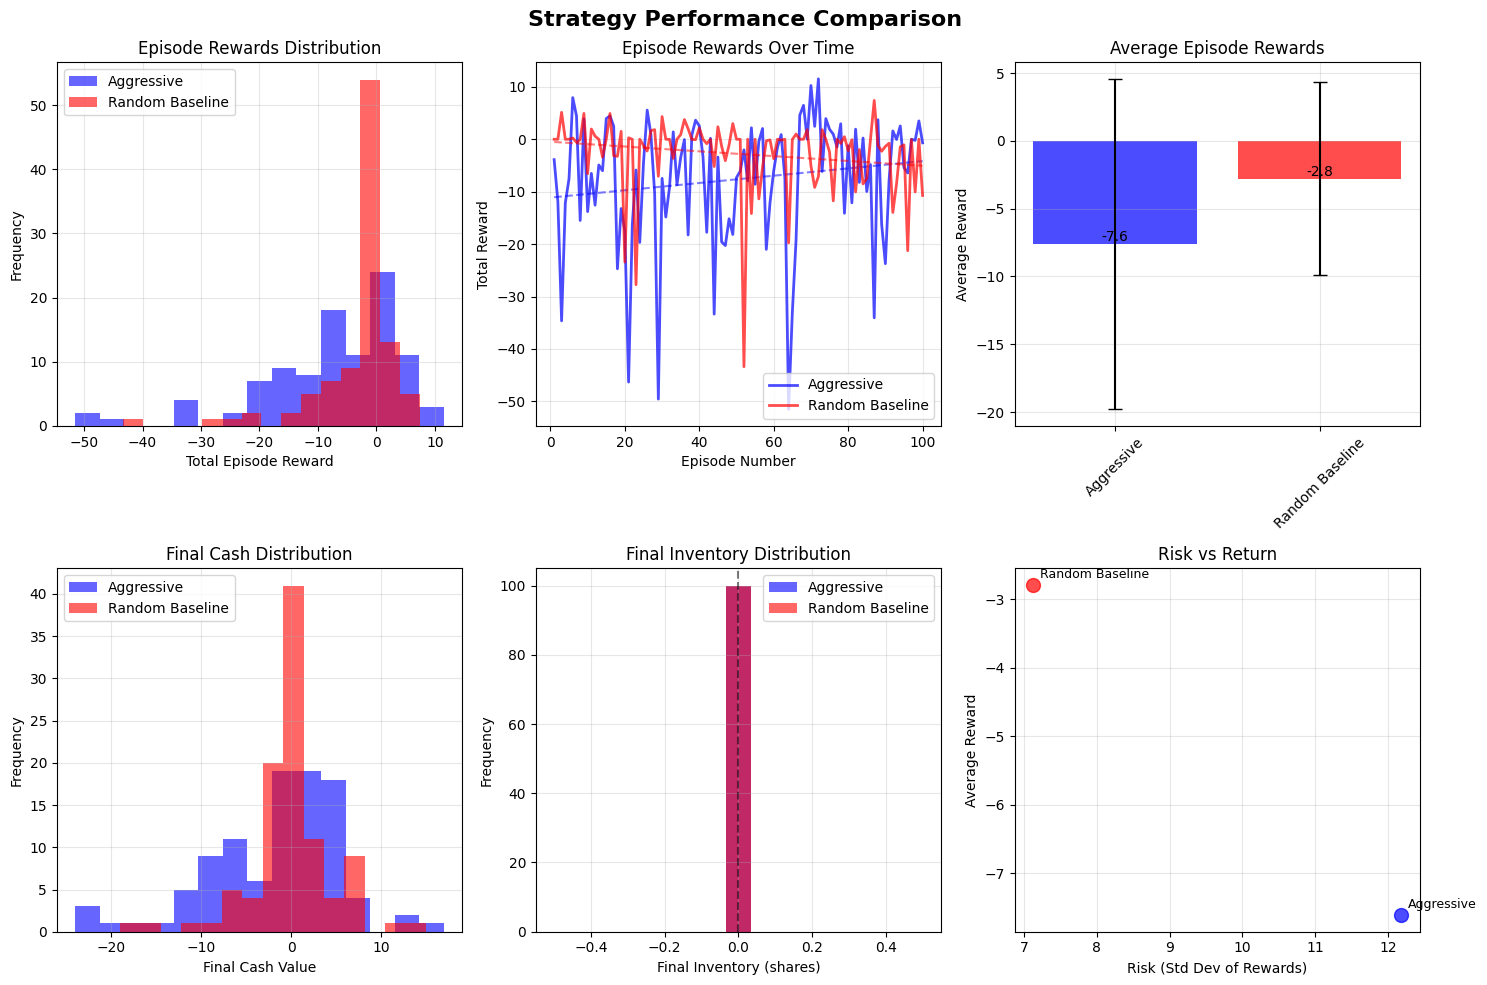


STRATEGY PERFORMANCE SUMMARY
Strategy        Avg Reward   Std Dev    Final Cash   |Final Inv| 
----------------------------------------------------------------------
Aggressive      -7.61        12.18      -1.64        0.00        
Random Baseline -2.79        7.12       -0.10        0.00        

Comparison complete! Check the plots above.

Key insights to look for:
1. Which strategy has highest average rewards?
2. Which strategy is most consistent (lowest std dev)?
3. Which strategy manages inventory best (closest to zero)?
4. How do all strategies compare to random actions?


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def random_strategy(state):
    """
    Random strategy for comparison - chooses random valid actions

    Args:
        state: (inventory_bucket, time_bucket) - ignored for random strategy

    Returns:
        action: Random valid action
    """
    # Choose random depths between 1 and 5
    bid_depth = random.randint(1, 5)
    ask_depth = random.randint(1, 5)

    action = {
        'depths': [bid_depth, ask_depth],
        'market order': 0
    }

    return action

def test_strategy_with_details(strategy_function, strategy_name, num_episodes=20, verbose=False):
    """
    Test a strategy and collect detailed performance data

    Args:
        strategy_function: Function that takes state and returns action
        strategy_name: Name of the strategy for plotting
        num_episodes: Number of episodes to test
        verbose: Whether to print detailed step-by-step info

    Returns:
        Dictionary with performance metrics and episode data
    """
    # Import the environment (you'll need to adjust this import)
    # from your_file import MonteCarloEnv

    # Create environment
    env = MonteCarloEnv(
        num_levels=10,
        max_quote_depth=5,
        num_inv_buckets=3,
        T=50,  # Shorter episodes for testing
        kappa=3,
        phi=0.01,
        default_order_size=5
    )

    # Data collection
    episode_rewards = []
    episode_final_cash = []
    episode_final_inventory = []
    episode_lengths = []
    all_rewards = []  # All step rewards across all episodes
    all_inventories = []  # All inventories across all episodes
    all_cash_values = []  # All cash values across all episodes

    for episode in range(num_episodes):
        env.reset()
        state = env.state()
        episode_reward = 0
        step_rewards = []
        step_inventories = []
        step_cash = []

        if verbose and episode < 3:  # Only show details for first 3 episodes
            print(f"\n--- {strategy_name} Episode {episode + 1} ---")
            print(f"Starting state: {state}")
            print(f"(inventory_bucket={state[0]}, time_bucket={state[1]})")

        step_count = 0
        while env.t < env.T:
            # Get action from strategy
            action = strategy_function(state)

            # Take step in environment
            next_state, reward = env.step(action)

            # Record step data
            step_rewards.append(reward)
            step_inventories.append(env.Q_t)
            step_cash.append(env.X_t)

            if verbose and episode < 3:
                print(f"Time {env.t-1}: State {state} -> Action {action['depths']} -> Reward {reward:.2f}")
                print(f"  Inventory: {env.Q_t}, Cash: {env.X_t:.2f}")

            episode_reward += reward
            state = next_state
            step_count += 1

            if env.t >= env.T:
                break

        # Store episode data
        episode_rewards.append(episode_reward)
        episode_final_cash.append(env.X_t)
        episode_final_inventory.append(env.Q_t)
        episode_lengths.append(step_count)

        # Store all step data
        all_rewards.extend(step_rewards)
        all_inventories.extend(step_inventories)
        all_cash_values.extend(step_cash)

        if verbose and episode < 3:
            print(f"Episode {episode + 1} total reward: {episode_reward:.2f}")
            print(f"Final: Cash={env.X_t:.2f}, Inventory={env.Q_t}")

    # Calculate statistics
    avg_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    avg_final_cash = np.mean(episode_final_cash)
    avg_final_inventory = np.abs(np.mean(episode_final_inventory))

    print(f"\n{strategy_name} Results:")
    print(f"Average episode reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Average final cash: {avg_final_cash:.2f}")
    print(f"Average final |inventory|: {avg_final_inventory:.2f}")

    return {
        'strategy_name': strategy_name,
        'episode_rewards': episode_rewards,
        'episode_final_cash': episode_final_cash,
        'episode_final_inventory': episode_final_inventory,
        'episode_lengths': episode_lengths,
        'all_rewards': all_rewards,
        'all_inventories': all_inventories,
        'all_cash_values': all_cash_values,
        'avg_reward': avg_reward,
        'std_reward': std_reward
    }

def compare_strategies(strategy_list, num_episodes=100):
    """
    Compare multiple strategies and create comprehensive plots

    Args:
        strategy_list: List of tuples (strategy_function, strategy_name)
        num_episodes: Number of episodes to test each strategy
    """

    print("Testing and comparing strategies...")
    print(f"Running {num_episodes} episodes per strategy")
    print("=" * 50)

    results = []

    # Test each strategy
    for strategy_func, strategy_name in strategy_list:
        print(f"\nTesting {strategy_name}...")
        result = test_strategy_with_details(strategy_func, strategy_name, num_episodes, verbose=False)
        results.append(result)

    # Create comprehensive plots
    create_comparison_plots(results)

    return results

def create_comparison_plots(results):
    """
    Create multiple plots comparing strategy performance

    Args:
        results: List of result dictionaries from test_strategy_with_details
    """

    # Set up the plotting style
    plt.style.use('default')
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Strategy Performance Comparison', fontsize=16, fontweight='bold')

    # Plot 1: Episode Rewards Distribution
    ax = axes[0, 0]
    for i, result in enumerate(results):
        ax.hist(result['episode_rewards'], alpha=0.6, label=result['strategy_name'],
                color=colors[i % len(colors)], bins=15)
    ax.set_title('Episode Rewards Distribution')
    ax.set_xlabel('Total Episode Reward')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Episode Rewards Over Time
    ax = axes[0, 1]
    for i, result in enumerate(results):
        episodes = range(1, len(result['episode_rewards']) + 1)
        ax.plot(episodes, result['episode_rewards'], label=result['strategy_name'],
                color=colors[i % len(colors)], alpha=0.7, linewidth=2)

        # Add trend line
        z = np.polyfit(episodes, result['episode_rewards'], 1)
        p = np.poly1d(z)
        ax.plot(episodes, p(episodes), '--', color=colors[i % len(colors)], alpha=0.5)

    ax.set_title('Episode Rewards Over Time')
    ax.set_xlabel('Episode Number')
    ax.set_ylabel('Total Reward')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Average Rewards Comparison (Bar Chart)
    ax = axes[0, 2]
    strategy_names = [r['strategy_name'] for r in results]
    avg_rewards = [r['avg_reward'] for r in results]
    std_rewards = [r['std_reward'] for r in results]

    bars = ax.bar(strategy_names, avg_rewards, yerr=std_rewards, capsize=5,
                  color=[colors[i % len(colors)] for i in range(len(results))],
                  alpha=0.7)
    ax.set_title('Average Episode Rewards')
    ax.set_ylabel('Average Reward')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, avg_reward in zip(bars, avg_rewards):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{avg_reward:.1f}', ha='center', va='bottom')

    # Plot 4: Final Cash Values
    ax = axes[1, 0]
    for i, result in enumerate(results):
        ax.hist(result['episode_final_cash'], alpha=0.6, label=result['strategy_name'],
                color=colors[i % len(colors)], bins=15)
    ax.set_title('Final Cash Distribution')
    ax.set_xlabel('Final Cash Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 5: Final Inventory Distribution
    ax = axes[1, 1]
    for i, result in enumerate(results):
        ax.hist(result['episode_final_inventory'], alpha=0.6, label=result['strategy_name'],
                color=colors[i % len(colors)], bins=15)
    ax.set_title('Final Inventory Distribution')
    ax.set_xlabel('Final Inventory (shares)')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Zero Inventory')

    # Plot 6: Risk vs Return Scatter
    ax = axes[1, 2]
    for i, result in enumerate(results):
        avg_reward = result['avg_reward']
        risk = result['std_reward']  # Using std deviation as risk measure
        ax.scatter(risk, avg_reward, s=100, label=result['strategy_name'],
                  color=colors[i % len(colors)], alpha=0.7)

        # Add strategy name as text
        ax.annotate(result['strategy_name'], (risk, avg_reward),
                   xytext=(5, 5), textcoords='offset points', fontsize=9)

    ax.set_title('Risk vs Return')
    ax.set_xlabel('Risk (Std Dev of Rewards)')
    ax.set_ylabel('Average Reward')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Create a summary table
    print("\n" + "="*70)
    print("STRATEGY PERFORMANCE SUMMARY")
    print("="*70)
    print(f"{'Strategy':<15} {'Avg Reward':<12} {'Std Dev':<10} {'Final Cash':<12} {'|Final Inv|':<12}")
    print("-"*70)

    for result in results:
        avg_cash = np.mean(result['episode_final_cash'])
        avg_inv = np.mean(np.abs(result['episode_final_inventory']))
        print(f"{result['strategy_name']:<15} {result['avg_reward']:<12.2f} {result['std_reward']:<10.2f} "
              f"{avg_cash:<12.2f} {avg_inv:<12.2f}")

# Example usage with all strategies:
def run_strategy_comparison():
    """
    Run a complete comparison of all strategies including random baseline
    """

    strategies_to_test = [
        #(balanced_strategy, "Balanced"),
        #(conservative_strategy, "Conservative"),
        (aggressive_strategy, "Aggressive"),
        (random_strategy, "Random Baseline")
    ]

    print("Starting comprehensive strategy comparison...")
    print("This will test each strategy over multiple episodes and create plots.")

    results = compare_strategies(strategies_to_test, num_episodes=100)

    print("\nComparison complete! Check the plots above.")
    print("\nKey insights to look for:")
    print("1. Which strategy has highest average rewards?")
    print("2. Which strategy is most consistent (lowest std dev)?")
    print("3. Which strategy manages inventory best (closest to zero)?")
    print("4. How do all strategies compare to random actions?")

    return results

# To run the comparison, uncomment this line:
results = run_strategy_comparison()

# For a quick test with fewer episodes:
# quick_results = compare_strategies([
#     (balanced_strategy, "Balanced"),
#     (random_strategy, "Random")
# ], num_episodes=20)